# Walmart : Sales in Stormy Weather

<img src="data/walmart.jpg">

# [ Overview ]

### (1) 목표 : 
> ### 20 지역에서 관측한 날씨에 따른, 월마트 매장 45곳에서 판매하는 111가지 품목의 판매량( `units` )을 예측한다.

### (2) 데이터
> #### train : 4617600 rows, 4 columns  
> - 2012년 1월 1일 ~ 2014년 10월 31일 사이 월마트 매장 45곳에서 판매하는 111가지 품목의 판매량 데이터  

> #### key : 45 rows, 2 columns
> - 20 지역의 관측소와, 같은 지역에 위치한 월마트 매장 45곳의 표  

> #### weather : 20517 rows, 20 columns
> - 2012년 1월 1일 ~ 2014년 10월 31일 사이 20지역의 날씨 데이터  
> - 온도 : Fahrenheit
- 풍속 : mph
- `snowfall`, `preciptotal` : inch  
- M : Missing 
- T : Trace ( 땅이 젖었 때 )
**Weather Data 각 Columns**
    - date : 날짜
    - tmax : 최대 온도
    - tmin : 최저 온도
    - depart : 과거 30년 동안의 최대온도의 평균과 `tmax`값의 차
    - dewpoint : 평균 이슬점
    - wetbulb : 평균 습도
    - heat : 난방 지수 (65 - `avg`) 1 ~ 6월 적용
    - cool : 냉방 지수 (`tavg` - 65) 7 ~ 12월 적용
    - sunrise : 일출 시간
    - sunset : 일몰 시간 
    - codesum : 특이 날씨 코드
        - +FC : TORNADO/WATERSPOUT
        - FC : FUNNEL CLOUD
        - TS : THUNDERSTORM
        - GR : HAIL
        - RA : RAIN
        - DZ : DRIZZLE
        - SN : SNOW
        - SG : SNOW GRAINS
        - GS : SMALL HAIL &/OR SNOW PELLETS
        - PL : ICE PELLETS
        - IC : ICE CRYSTALS
        - FG+: HEAVY FOG (FG & LE.25 MILES VISIBILITY)
        - FG : FOG
        - BR : MIST
        - UP : UNKNOWN PRECIPITATION
        - HZ : HAZE
        - FU : SMOKE
        - VA : VOLCANIC ASH
        - DU : WIDESPREAD DUST
        - DS : DUSTSTORM
        - PO : SAND/DUST WHIRLS
        - SA : SAND
        - SS : SANDSTORM
        - PY : SPRAY
        - SQ : SQUALL
        - DR : LOW DRIFTING
        - SH : SHOWER
        - FZ : FREEZING
        - MI : SHALLOW
        - PR : PARTIAL
        - BC : PATCHES
        - BL : BLOWING
        - VC : VICINITY
        - (-) : LIGHT
        - (+) : HEAVY
        - "NO SIGN" : MODERATE
    - snowfall : 눈이 쌓인 정도 (inches)
    - precipitotal : 24시간 기준 강수량 (inches)
    - stnpressure : 평균 기압
    - sealevel : 해수면 압력
    - resultspeed : 합성 풍속 (mph)
    - resultdir : 합성 풍향 (10도씩) 
    - avgspeed : 평균 풍속 (mph)

        
> #### test : 526917 rows, 3 columns
> - 2013년 4월 1일 ~ 2014년 10월 26일 사이 월마트 매장 44곳 (35번 매장 누락) 에 대한 템플릿 

# Load Data

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd

### train

In [2]:
train = pd.read_csv("data/train.csv")
print(train.shape)
train.tail()

(4617600, 4)


,date,store_nbr,item_nbr,units
4617595,2014-10-31,45,107,0
4617596,2014-10-31,45,108,0
4617597,2014-10-31,45,109,0
4617598,2014-10-31,45,110,0
4617599,2014-10-31,45,111,0


### keys

In [3]:
keys = pd.read_csv("data/key.csv")
print(keys.shape)
keys.head()

(45, 2)


,store_nbr,station_nbr
0,1,1
1,2,14
2,3,7
3,4,9
4,5,12


### weather

In [4]:
weather_1 = pd.read_csv("data/weather.csv")

# input data in order to reflect [ "NO SIGN" : MODERATE ] in description
def codesum_moderate(codesum):
    if codesum == " ":
        return "moderate"
    else:
        return codesum
        
weather_1['codesum'] = weather_1['codesum'].apply(codesum_moderate)

print(weather_1.shape)
weather_1.head()

(20517, 20)


,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2012-01-01,52,31,42,M,36,40,23,0,-,-,RA FZFG BR,M,0.05,29.78,29.92,3.6,20,4.6
1,2,2012-01-01,48,33,41,16,37,39,24,0,0716,1626,RA,0.0,0.07,28.82,29.91,9.1,23,11.3
2,3,2012-01-01,55,34,45,9,24,36,20,0,0735,1720,moderate,0.0,0.00,29.77,30.47,9.9,31,10.0
3,4,2012-01-01,63,47,55,4,28,43,10,0,0728,1742,moderate,0.0,0.00,29.79,30.48,8.0,35,8.2
4,6,2012-01-01,63,34,49,0,31,43,16,0,0727,1742,moderate,0.0,0.00,29.95,30.47,14.0,36,13.8


### Merge train & weather by keys

In [5]:
df_1 = pd.merge(weather_1, keys)
df_1 = pd.merge(df_1, train)

# # split date
# def make_year(date):
#     return int(date.split('-')[0])
# def make_month(date):
#     return int(date.split('-')[1])
# def make_day(date):
#     return int(date.split('-')[2])
# df_1['year'] = df_1['date'].apply(make_year)
# df_1['month'] = df_1['date'].apply(make_month)
# df_1['day'] = df_1['date'].apply(make_day)

# # create new column 'codesum_YN' for 'Ab' as abnormal & 'Mo' as moderate
# def codesum_YN(codesum):
#     if codesum == " ":
#         return "Mo"
#     else:
#         return "Ab"
# df_1['codesum_YN'] = df_1['codesum'].apply(codesum_YN)


print(df_1.shape)
df_1.head()

(4617600, 23)


,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,store_nbr,item_nbr,units
0,1,2012-01-01,52,31,42,M,36,40,23,0,...,M,0.05,29.78,29.92,3.6,20,4.6,1,1,0
1,1,2012-01-01,52,31,42,M,36,40,23,0,...,M,0.05,29.78,29.92,3.6,20,4.6,1,2,0
2,1,2012-01-01,52,31,42,M,36,40,23,0,...,M,0.05,29.78,29.92,3.6,20,4.6,1,3,0
3,1,2012-01-01,52,31,42,M,36,40,23,0,...,M,0.05,29.78,29.92,3.6,20,4.6,1,4,0
4,1,2012-01-01,52,31,42,M,36,40,23,0,...,M,0.05,29.78,29.92,3.6,20,4.6,1,5,0


(description)

1. 본격적으로 회귀를 시작하기 앞서, 우리가 가지고 있는 데이터에 대해 파악했음.
2. 총 45개 store, 20개 station, 각 station마다 여러 개의store의 weather data를 관측. weather data는 2012년 2월부터 2014년까지 10월까지 있음.
3. 아이템 종류를 의미하는 item_nbr, 각 item_nbr마다 판매량을 나타내는 units가 있다. 총 item_nbr는 111개지만 모든 store에서 111개가 전부 팔리진 않고 한 store당 4~5개 정도 팔림. 우리가 예측해야 할 예측치는 45 X 5
4. 판매량과 날씨 데이터를 결합했을때 총 데이터 수는 460만개

# 1. EDA
1. 우리는 units의 예측치를 구해야 하므로 이 units에 대해 어떻게 접근할 지 고민했음
2. 일단 각 store의 연도별 units 경향을 살펴보기로 함

## 1. 1. Check tendency (경향을 확인하기)

In [11]:
import scipy as sp
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid")

df_tmp = df_1.copy()

### 1. 1. 1.  `year` , `store_nbr` vs `units`

In [ ]:
def show_tendency(store_number):
    '''
    input : store_nbr
    output : graph represetning total units for each year, each month
    '''
    
    # split year, month     
    def make_year(date):
        return int(date.split('-')[0])
    def make_month(date):
        return int(date.split('-')[1])
    df_tmp['year'] = df_tmp['date'].apply(make_year)
    df_tmp['month'] = df_tmp['date'].apply(make_month)
    
    
    # show yearly units tendency by store_nbr
    store_month = df_tmp.pivot_table(index=['year','month'],columns='store_nbr',values='units',aggfunc=np.sum)
    
    target_store = store_month[store_number]
    that_2012 = target_store.loc[2012]
    that_2013 = target_store.loc[2013]
    that_2014 = target_store.loc[2014]
    
    plt.figure(figsize=(12,8))
    plt.plot(that_2012,label='2012',c='blue',ls='--',lw=4)
    plt.plot(that_2013,label='2013',c='green',ls=':',marker='D',ms=10,lw=4)
    plt.plot(that_2014,label='2014',c='red',lw=4)
    plt.legend(loc='best',prop={'size':20})
    plt.show()

In [ ]:
show_tendency(2)

위 plot은 2번 store에서의 units경향이다.

2013년과 2014년에서 units가 떨어진 것으로 보아, 

이 시점에서의 weather를 비교해보면 뭔가 insight를 얻을 수 있지 않을까, 그래서 해당 store에서 item_nbr는 뭐가 팔렸고 얼마나 팔렸는지 찍어봤다

### 1. 1. 2.  `year`, `month`, `store_nbr` vs `units`

In [ ]:
def item_nbr_tendency(store_nbr):
    '''
    input : store_nbr
    output : graph representing units groupped by each year, each month
    '''
    store = df_tmp[df_tmp['store_nbr'] == store_nbr]

    pivot = store.pivot_table(index=['year','month'],columns='item_nbr',values='units',aggfunc=np.sum)
    zero_index = pivot==0
    pivot = pivot[pivot!=0].dropna(axis=1,how='all')
    pivot[zero_index]=0
    
    
    pivot_2012 = pivot.loc[2012]
    pivot_2013 = pivot.loc[2013]
    pivot_2014 = pivot.loc[2014]
    
    plt.figure(figsize=(12,8))
    plt.subplot(131)
    sns.heatmap(pivot_2012,cmap="YlGnBu", annot = True, fmt = '.0f')
    plt.subplot(132)
    sns.heatmap(pivot_2013,cmap="YlGnBu", annot = True, fmt = '.0f')
    plt.subplot(133)
    sns.heatmap(pivot_2014,cmap="YlGnBu", annot = True, fmt = '.0f')
    plt.show()

In [ ]:
item_nbr_tendency(1)

위 plot은 해당 store에서 한번이라도 팔린 item에 대한 units를 year, month별로 출력한 것이다.

어떤 item_nbr의 units가 떨어졌는지 확인할 순 있지만 month별로 출력했기 때문에 각 day별로는 확인할 수 없다.

day별로 확인할 수 없다면 weather feature가 각 날짜에 얼마나 영향을 미쳤는지 정확히 조사할 수 없다.

따라서 day별로 plot을 찍어봤다

### 1. 1. 3.  `year`, `month`, `day`, `store_nbr`, `item_nbr` vs `units`

In [ ]:
def item_nbr_tendency_finely(store_nbr, year, month_start=-1, month_end=-1, graph=True):
    '''
    input
        1. store_nbr = 스토어 번호
        2. year = 연도
        3. month_start = 시작달
        4. month_start = 끝달
        5. graph = 위의 정보에 대한 item_nbr 그래프 출력여부
    
    output
        1. store_nbr, year, month로 filtering한 item_nbr의 pivot 테이블
    '''
    store = df_1[(df_1['store_nbr'] == store_nbr) &
                 (df_1['year'] == year)]

    if month_start != -1:
        if month_end == -1:
            month_end = month_start + 1
        store = store[(month_start <= store['month']) & (store['month'] < month_end)]

    pivot = store.pivot_table(index='item_nbr',
                              columns='date',
                              values='units',
                              aggfunc=np.sum)

    zero_index = pivot == 0
    pivot = pivot[pivot != 0].dropna(axis=0, how='all')
    pivot[zero_index] = 0

    if graph:
        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot, cmap="YlGnBu", annot=True, fmt='.0f')
        plt.show()

    return pivot

In [ ]:
item_nbr_tendency_finely(1,2012,1)

각 day별로 해당 item_nbr와 date, units를 pivot하여 찍은 plot이다.

각 날짜에 어떤 units변화가 일어났는지 weather와 같이 비교해볼 수 있는 형태가 됬고, 아래의 plot은 위와 똑같은 기간의 weather 데이터다.




In [ ]:
def weather_tendency(store_nbr, year, month_start = -1, month_end = -1):
    '''
    input:
        위와 같음
        
    output:
        위의 정보로 filtering한 train,key,weather DataFrame
    '''
    store = df_1[(df_1['store_nbr'] == store_nbr) &
                 (df_1['year'] == year)]
    
    if month_start!=-1:
        if month_end == -1:
            month_end = month_start + 1
        store = store[(month_start <= store['month']) & (store['month'] < month_end)]
    
    store = store.drop(labels=['item_nbr','units'],axis=1)
#     store = store.iloc[:,:]
    
    store = store.drop_duplicates(keep='first').reset_index(drop=True)
    
    store.index.name='date'
    store.index = store['date']
        
    return store

In [ ]:
weather_tendency(1,2012).head()

units의 변화량에 대해 각 날짜별로 비교할 수 있지만, 

일일이 비교해서 유의미한 insight를 도출하기엔 비현실적이다.

그래서 아래와 같이 입력받은 스토어에 대해서,

모든 item_nbr에 대한 weather feature VS units의 피어슨 상관계수를 구한 것이 아래다

In [ ]:
def get_correlation(store_nbr, year, month_start=-1, month_end=-1):
    '''
    input:
        위와 같음
    output:
        missing, tracing data를 제외한
        팔린 item_nbr별 각 weather feature에 대한 pearsonr, pvalue를 담은 dictionary
    '''

    '''
    Use-case
        1. 7번 store, 2012년 1월부터 12월까지 item_nbr별 상관관계를 알고 싶다
        get_correlation(7,2012)
        
        2. 7번 store, 2012년 1월부터 3월까지 item_nbr별 상관관계를 알고 싶다
        get_correlation(7,2012,1,3)
        
        3. 7번 store, 2012년 5월만 item_nbr별 상관관계를 알고 싶다
        get_correlation(7,2012,5)
    '''
    correlation = dict()

    units_table = item_nbr_tendency_finely(store_nbr, year, month_start, month_end, graph=False)
    weather_table = weather_tendency(store_nbr, year, month_start, month_end)

    weather = list(weather_table.columns[3:20])
    weather.remove('codesum')

    item_nbr = units_table.index

    inner = dict()

    for feature in weather:
        for units in item_nbr:

            a = weather_table[feature].copy()
            b = units_table.loc[units].copy()

            a = a.apply(lambda x: x.replace(' ', ''))
            a = a.apply(lambda x: x.replace('-', ''))

            missing_index = (a.str.contains('M')) | (a.str.contains('T'))
            nothing_index = a.apply(lambda x: len(x)) == 0

            a[missing_index] = np.nan
            b[missing_index] = np.nan

            a[nothing_index] = np.nan
            b[nothing_index] = np.nan
            
            a.dropna(axis=0, inplace=True)
            b.dropna(axis=0, inplace=True)

            inner[(units, feature, len(a))] = sp.stats.pearsonr(a.astype(float), b)

            correlation[(store_nbr, year, month_start, month_end-1)] = inner

    return correlation


def show_me_pearson(pearson_dict):

    for key,val in pearson_dict.items():
        print(key, '\n')
        
        if isinstance(val,dict):
            printee = []
            keys = list(val.keys())
            keys.sort()
            printee += [(k,val[k]) for k in keys]
        
        else:
            printee = val
        
        for each in printee:
            print('\t',each)
            
            
def trim_correlation(correlation_dict):

    keys = correlation_dict.keys()
    result = dict()
    
    for key in keys:
        inner_dict = correlation_dict[key]
        item_nbrs = list(set(each[0] for each in inner_dict.keys()))
        sorted_filtered = filter_sort_inner_dict(inner_dict, item_nbrs)
        
        result[key] = sorted_filtered
        
    return result  


def filter_sort_inner_dict(inner_dict, item_nbrs):

    pvalue_filtered = [(key,val) for key,val in inner_dict.items() if val[1] < 0.01]
    pearsonr_sorted = []
    
    for item_nbr in item_nbrs:
        pearsonr_sorted += sort_inner_dict(item_nbr,pvalue_filtered)
    
    return pearsonr_sorted


def sort_inner_dict(item_nbr, filtered):

    each_item = [each for each in filtered if each[0][0]==item_nbr]
    each_item = sorted(each_item, key = lambda each: abs(each[1][0]), reverse=True)
    
    return each_item

In [ ]:
show_me_pearson(trim_correlation(get_correlation(1,2012)))

### 1. 1. 4.  `codesum` 발생 여부 vs `units`

In [12]:
def show_codesum_vs_units(station_nbr):

    
    # create new column 'codesum_YN' : 'Ab' as codesum occured, 'Mo' as moderate weather
    def codesum_YN(codesum):
        if codesum == "moderate":
            return "Mo"
        else:
            return "Ab"
    df_tmp['codesum_YN'] = df_tmp['codesum'].apply(codesum_YN)
    
    # show only rows with units sales occured
    df_tmp_2 = df_tmp[df_tmp['units'] > 0].reset_index(drop=True)
    
    # caculate sales difference between codesum vs no codesum in percentage
    pivot_data = df_tmp_2.pivot_table(index=['station_nbr', 'item_nbr'],columns=['codesum_YN'],values='units', aggfunc='sum')
    pivot_data['Difference(%)'] = ((pivot_data['Ab'] - pivot_data['Mo']) / pivot_data['Mo'] * 100).round(2)
    pivot_data.drop(columns=['Ab', 'Mo'], inplace=True)
    station = pivot_data.loc[station_nbr]
    station = station.reset_index(drop=False)
    
    # seaborn barplot
    fig = plt.figure(figsize=(20, 6))
    sns.barplot(x='item_nbr', y='Difference(%)', data=station)
    plt.show()

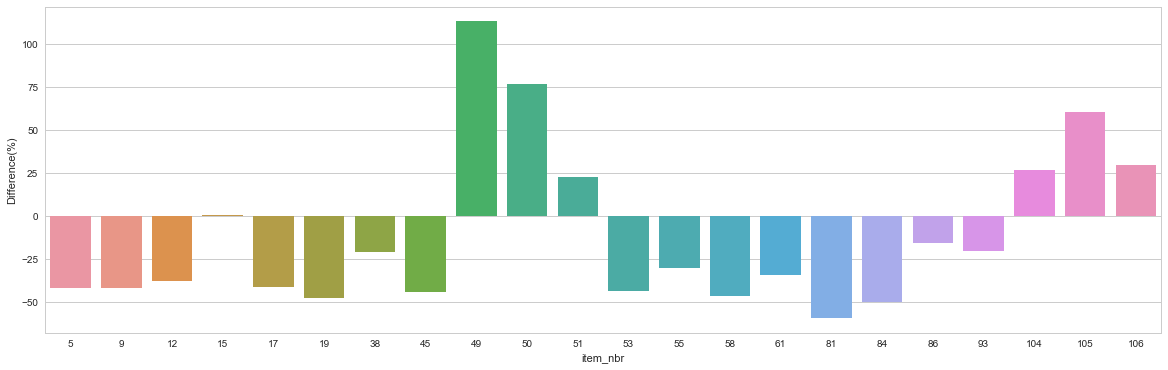

In [14]:
show_codesum_vs_units(13)

------------------------------------------------

# 1. 2. Identify Missing Data

### 1. 2. 1. Transform all missing data into `np.nan`

In [15]:
for i in weather_1.columns:
    print(i, "\n", weather_1[i].unique())

station_nbr 
 [ 1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20  5]
date 
 ['2012-01-01' '2012-01-02' '2012-01-03' ..., '2014-10-29' '2014-10-30'
 '2014-10-31']
tmax 
 ['52' '48' '55' '63' '50' '66' '34' '73' '72' '38' '56' '59' '46' '45' '60'
 '44' '21' '65' '43' '53' '25' '32' '28' '62' '61' '47' '30' '26' '71' '58'
 '39' '54' '23' '27' '31' '68' '70' '67' '36' '69' '74' '75' '33' '51' '57'
 '41' '49' '76' '35' '77' '64' '40' '16' '37' '42' '14' '22' '13' '10' '20'
 '24' '80' '4' '11' '78' '17' '18' '79' '29' '81' '82' '83' '88' '87' '92'
 '89' '84' '85' '86' '90' '91' '94' '93' '96' '95' 'M' '97' '98' '101' '99'
 '100' '105' '103' '102' '106' '104' '109' '107' '108' '110' '111' '112'
 '114' '113' '19' '15' '12' '-1' '5' '8' '9' '1' '6' '2' '3' '7' '-2' '-11'
 '-4' '-6' '0']
tmin 
 ['31' '33' '34' '47' '45' '19' '53' '48' '18' '26' '30' '38' '40' '25' '41'
 '28' '24' '37' '36' '11' '16' '29' '22' '35' '15' '9' '21' '27' '10' '5'
 '32' '20' '3' '8' '44' '46' '17' '55' '43' '57

### Types of Missing Data : ` - `, ` M `, ` T `, `  T`, `(blank)`

In [16]:
for i in weather_1.columns:
    weather_1[i] = weather_1[i].replace('-', np.nan)
    weather_1[i] = weather_1[i].replace(' ', np.nan)
    weather_1[i] = weather_1[i].replace('M', np.nan)
    weather_1[i] = weather_1[i].replace('T', np.nan)
    weather_1[i] = weather_1[i].replace('  T', np.nan)

### 1. 2. 2. Visualize Missing Data

### 1. 2. 2. 1. All

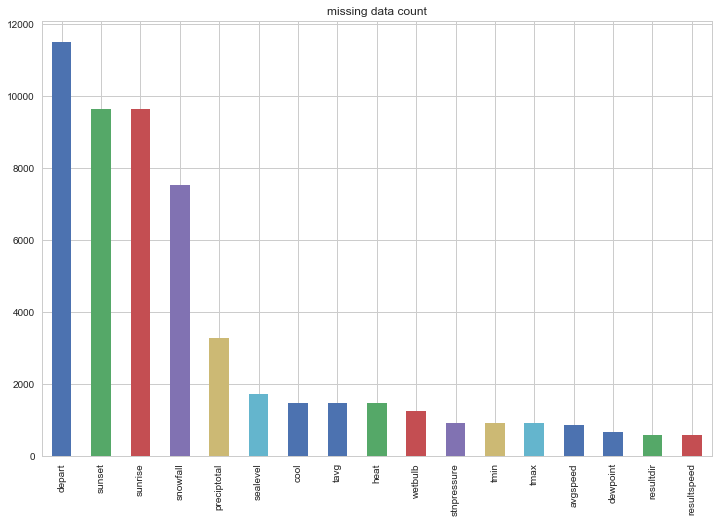

In [17]:
plt.figure(figsize=(12,8))
count_null = weather_1.isnull().sum()
count_null.sort_values(ascending = False, inplace = True)
count_null = count_null[count_null > 0]
count_null.plot(kind = 'bar', title = 'missing data count')
plt.show()

### 1. 2. 2. 2. Missing Data by each Station

In [18]:
def station_null(station_nbr):
    print("Total data size of station_" + str(station_nbr) + " : " + str(len(weather_1[weather_1['station_nbr'].isin([5])])))
    
    plt.figure(figsize=(16,4))
    count_null = weather_1[weather_1['station_nbr'].isin([station_nbr])].isnull().sum()
    count_null.sort_values(ascending = False, inplace = True)
    count_null = count_null[count_null > 0]
    count_null.plot(kind = 'bar', title = 'missing data count')
    plt.show()

Total data size of station_5 : 852


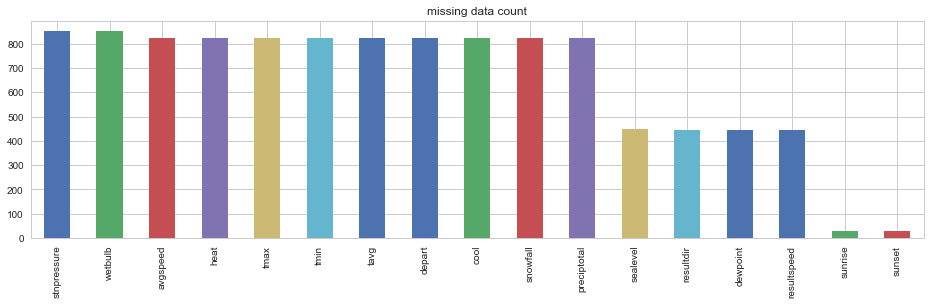

In [19]:
station_null(5)

# 2 Preprocessing

## 2. 1. Missing Value Imputation

모델링하기 전에 데이터의 복원에 대해서 고려해야 했다.
missing value가 발행하지 않은 데이터만 가지고 modeling을 할 수는 없다

1. OLS가 안 돌아간다.

2. 완전한 데이터만 걸렀을 때는 
- 빠져버리는 store가 발생하기 때문에
- missing value가 하나도 없는 데이터는 7000개 뿐이다.
- 제공받은 데이터 중 완전한 데이터, 즉 일부만 사용한다면 편향된 결과를 도출할 수 있기 때문에

---------------

3가지 방법의 Imputation

1. yesterday = 어제 날짜를 참조하여 복원
2. mean = 해당 station의 해당 feature의 평균으로 복원
3. best close = missing 행과 가장 비슷한 행을 찾아 복원

모델링에 쓰일 데이터는 위의 세가지 복원버전을 사용한다.

--------------

1. 전체 station에서 intact한 row들을 뽑음
2. 모든 intact한 row를 고려하면 시간이 오래 걸리므로 DataFrame.sample함수를 이용하여 랜덤하게 추출
3. missing이 발생한 행에 대해서 intact한 row와 가장 가까운 행을 찾음
4. 이 때 기준은 각 feature의 Z-score (모든 feature를 공평하게 반영하여 가까운 행을 찾음)
5. 이 Z-score의 차이가 가장 적은 행이 가장 가까운 행이다.

## 2. 3. Encoding

In [ ]:
# # split date
# def make_year(date):
#     return int(date.split('-')[0])
# def make_month(date):
#     return int(date.split('-')[1])
# def make_day(date):
#     return int(date.split('-')[2])
# df_1['year'] = df_1['date'].apply(make_year)
# df_1['month'] = df_1['date'].apply(make_month)
# df_1['day'] = df_1['date'].apply(make_day)

# # create new column 'codesum_YN' for 'Ab' as abnormal & 'Mo' as moderate
# def codesum_YN(codesum):
#     if codesum == " ":
#         return "Mo"
#     else:
#         return "Ab"
# df_1['codesum_YN'] = df_1['codesum'].apply(codesum_YN)

## 2. 4 Final Merge for Modeling

# 3. Modeling

우리의 종속변수는 units다.

이에 대해 고려해야 할 독립변수는 우리가 제공받은 weather데이터의 각 feature column들이다. 

(tavg, tmin, dewpoint, codesum etc 2~3개 정도로 간략하게 설명)

feature들은 실수형, 카테고리형 둘 다를 포함하고,

우리는 기본적으로 두 형태의 모델링으로 시작했다.

1. store_nbr, item_nbr별로 data를 filtering한 가중치
2. store_nbr, item_nbr를 카테고리 변수로 갖는 가중치

---------------

### 첫번째 경우
item_nbr로만 filtering / store_nbr,item_nbr로 filtering

모두 해봤는데 알스퀘어값이 상당히 낮았고 수치가 전체적으로 unstable했음

아마도 모수값을 계산하는데 원래 모든 데이터가 작용해야 하는데 filtering된 데이터가 편파적으로 작용하여 올바른 계산이 되지 않은 것으로 보인다 (방정식의 수 vs 미지수의 수)

타당한 모델링이 아닌 것 같아서 이 경우는 제외함

In [ ]:
from pres_first import *
results=[0,]
total = 0
n = 0
for item_nbr in range(1,112):
    frame = data[data['item_nbr']==item_nbr]
    
    model = sm.OLS.from_formula(formula,data=frame)
    
    r2 = model.fit().rsquared
    
    if not np.isnan(r2):
#         print(item_nbr, r2)
        total+=r2
        n+=1
    
    if r2>=0.3:
        print(item_nbr,r2)
    
    results.append(model)

In [ ]:
results[1].fit().summary()

In [ ]:
# 각 item_nbr에 대한 모델의 알스퀘어값의 평균
total/n

### 두번째 경우
얘는 script임. 발표할 때 따로 어디다 적어놓고 읽을 것
1. 카테고리로 store_nbr, item_nbr를 줬을 때 알스퀘어값이 0.6정도 나옴.

2. 이 상태에서 복원한 각 버전으로 아웃라이어 제거, VIF로 다중공선성 제거, 각 실수 독립변수에 대해 scaling, 변수변환으로 각각 모델링 시행.

3. 독립변수에 몇가지를 더 추가하여 트레이닝한 결과 평균적으로 알스퀘어 값이 0.85정도 나옴.

4. 크로스 벨리데이션으로 측정했을 때도 알스퀘어 값이 균일했음. 오버피팅이 일어나지 않음 (오버피팅 안일어났으니까 정규화도 안했음)

5. 위 모든 결과를 통틀어 잔차는 정규성을 따르지 않았고 LL값도 낮았다. 

6. 잔차가 정규성을 따르지 않는다는 결과는 우리의 모델링이 실제를 충분히 반영하고 있지 않기 때문에, 즉 적합한 회귀선을 찾지 못해서라고 판단

7. 그래서 구해진 모델에 대해 잔차가 정규성을 따르게 해주는 조치를 취해주는 것보단 실제를 충분히 반영하는 모델을 찾아야겠다고 판단

8. 그 전에 구한 모델의 결과에서 어느 독립변수가 어떻게 종속변수에 끼치는지 알아보기 위해 각 독립변수와 종속변수의 plot을 찍어봤다.

9. 그랬더니 모든 실수 독립변수가 종속변수와 무상관관계를 나타냈다.

10. 데이터 복원이 잘못 됬나 싶어 제공받은 데이터 중 intact한 애들로만 따로 결과내서 찍어보니 모양도 똑같고 무상관관계였다.
(데이터 복원은 없는 경향까지 만들어내지 않는다)

11. 앞서 도출한 바를 바탕으로 모델링에서 실수 독립변수를 제외하고 독립변수로 카테고리 값만 줬는데도 결과엔 아무런 영향이 없었다. 실수 독립변수는 종속변수와 상관없음.

12. 독립변수에 요일을 나타내는 카테고리 변수 dayofweek을 추가하여 모델링한 결과 성능이 올랐다.

13. units(판매량)은 날씨에 대해선 영향을 받지 않는다. 온도가 어떻다던지, 습도가 어떻다던지. 다만 dayofweek을 추가했을 땐 영향을 받았는데 요일을 고려했을 때 실제를 더 충분히 반영하는 모델링일 것이기 때문이다.

14. 

# 1.

In [ ]:
from pres_second import *
formula = 'units ~ C(store_nbr) + C(item_nbr)+avgspeed + cool + depart + dewpoint + heat + preciptotal + resultdir + resultspeed + sealevel + snowfall + stnpressure + tavg + tmax + tmin + wetbulb'
model = sm.OLS.from_formula(formula,data=data)
result = model.fit()
result.summary()

# 2. 아웃라이어 제거 (R2)

In [ ]:
res = result.resid_pearson
index = result.resid.index
outlier_index = abs(res) >= 2

row = pd.Series(index=index, data=res)
drop_index = row[outlier_index].index
data.drop(list(drop_index),inplace=True)
data.reset_index(drop=True,inplace=True)

model = sm.OLS.from_formula(formula,data=data)
result = model.fit()
result.summary()

In [ ]:
res = result.resid_pearson
index = result.resid.index
outlier_index = abs(res) >= 2

row = pd.Series(index=index, data=res)
drop_index = row[outlier_index].index
data.drop(list(drop_index),inplace=True)
data.reset_index(drop=True,inplace=True)

model = sm.OLS.from_formula(formula,data=data)
result = model.fit()
result.summary()

# 2. 다중공선성 제거 (조건수)

In [ ]:
tmp = data.copy()
del tmp['tavg']
del tmp['sealevel']
del tmp['wetbulb']
del tmp['stnpressure']
del tmp['tmin']
del tmp['tmax']
del tmp['dewpoint']
del tmp['avgspeed']
del tmp['resultspeed']

In [ ]:
formula = 'units ~ C(store_nbr) + C(item_nbr)+ scale(cool) + scale(depart) + scale(heat) + scale(preciptotal) + scale(resultdir) + scale(snowfall)'
model = sm.OLS.from_formula(formula,data=tmp)
result = model.fit()
result.summary()

# 3. 추가한 독립변수 is_holiday, codesum

In [ ]:
tmp = tmp.merge(codesum, on = ['date','store_nbr'])
tmp['is_holiday'] = tmp['is_holiday'].apply(cate_holiday)
tmp['codesum'] = tmp['codesum'].apply(cate_codesum)
formula = 'units ~ C(store_nbr) + C(item_nbr)+ scale(cool) + scale(heat) + scale(preciptotal) + scale(snowfall) + is_holiday'

In [ ]:
model = sm.OLS.from_formula(formula,data=tmp)
result = model.fit()
result.summary()

# 4. cross-validation

In [ ]:
X = tmp.loc[:, ['store_nbr', 'item_nbr', 'cool', 'heat', 'preciptotal','snowfall', 'is_holiday']]
y = tmp.loc[:, ['units']]

from sklearn.model_selection import KFold

trial = 4

cv = KFold(n_splits=trial, shuffle=True, random_state=2)

total = 0


for train_index, test_index in cv.split(X):
    print("test index :", test_index, len(test_index))
    print("." * 80)
    print("train index:", train_index, len(train_index))
    print("=" * 80)

    X_train = X.loc[train_index, :]
    X_test = X.loc[test_index, :]
    y_train = y.loc[train_index, :]
    y_test = y.loc[test_index, :]

    model = sm.OLS.from_formula(
        formula, data=pd.concat([X_train, y_train], axis=1))
    result = model.fit()

    y_hat = result.predict(X_test)

    ESS = ((y_hat - y_hat.mean())**2).sum()
    TSS = ((y_test - y_test.mean())**2).sum()
    total += ESS / TSS
    print(ESS / TSS)

total / trial

# 5. 잔차의 정규성, LL

In [ ]:
result.summary()

# 8,9,10. 실수 독립변수 vs 종속변수

데이터의 경향을 보려고 했는데, 선형 관계를 확인할 수 없었다

In [ ]:
formula

In [ ]:
fig = sm.graphics.plot_regress_exog(result, "scale(heat)")
fig.suptitle("")
plt.show()

In [ ]:
fig = sm.graphics.plot_regress_exog(result, "scale(cool)")
fig.suptitle("")
plt.show()

In [ ]:
fig = sm.graphics.plot_regress_exog(result, "scale(preciptotal)")
fig.suptitle("")
plt.show()

In [ ]:
fig = sm.graphics.plot_regress_exog(result, "scale(snowfall)")
fig.suptitle("")
plt.show()

# 11. 카테고리 독립변수만 고려 (R2에 큰 차이가 없음)

In [ ]:
formula = 'units ~ C(store_nbr) + C(item_nbr)'
model = sm.OLS.from_formula(formula,data=tmp)
result = model.fit()
result.summary()

# 12. dayofweek 추가